In [1]:
%pylab inline
import pandas as pd
import dask.dataframe as dd
import os,sys
import logging
import fastparquet
import gc
import cPickle as pickle 

Populating the interactive namespace from numpy and matplotlib


In [2]:
from fbprophet import Prophet


In [3]:
master = pd.read_csv('https://www.fhfa.gov/DataTools/Downloads/Documents/HPI/HPI_master.csv')

In [4]:
master['level'].value_counts()

MSA                       73594
State                     24312
USA or Census Division     7200
Puerto Rico                 186
Name: level, dtype: int64

In [5]:
master['hpi_type'].value_counts()

traditional      99427
non-metro         4371
distress-free     1308
developmental      186
Name: hpi_type, dtype: int64

In [6]:
def read_po_monthly_hpi():
    df=master[(master['frequency']=='monthly') & (master['hpi_flavor']=='purchase-only')  & (master['hpi_type']=='traditional')]
    df['month'] = df[['yr','period']].apply(lambda u: pd.to_datetime('{}-{}-1'.format(u.values[0],u.values[1])),axis=1)
    df=pd.pivot_table(df,index=['month'], columns=['place_id'],values=['index_nsa'] )
    df.columns = df.columns.droplevel()
    df.columns=df.columns.map(lambda u: u.replace("DV_",""))
    #df=df[["MA",'ENC','WNC','SA','PAC']]    
    return df 

In [7]:
div_po_monthly=read_po_monthly_hpi()

/home/bo/miniconda2/envs/python27/lib/python2.7/site-packages/ipykernel/__main__.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  app.launch_new_instance()


In [8]:
#div_po_monthly=np.exp(np.log(div_po_monthly).diff(axis=0))

In [9]:
div_po_monthly.tail()

place_id       ENC     ESC      MA      MT      NE     PAC      SA     WNC  \
month                                                                        
2018-01-01  211.86  233.55  231.84  343.10  245.12  299.43  260.89  254.60   
2018-02-01  213.65  235.71  231.83  346.86  246.28  304.95  263.69  255.42   
2018-03-01  216.83  238.59  236.28  351.29  246.68  307.16  267.23  260.58   
2018-04-01  220.21  239.54  235.35  355.94  251.14  309.77  270.49  262.66   
2018-05-01  221.15  245.62  238.22  359.09  254.78  311.79  272.81  264.93   

place_id       WSC     USA  
month                       
2018-01-01  270.00  257.11  
2018-02-01  276.33  259.93  
2018-03-01  278.01  263.13  
2018-04-01  278.24  265.40  
2018-05-01  282.61  268.13

In [10]:
def pred(col,b_show=False):
    m = Prophet(seasonality_mode = 'multiplicative')#, mcmc_samples=300)
    #m = Prophet()
    df=div_po_monthly[col].reset_index()
    df.columns=['ds','y']
    df=df[df['ds']>=pd.to_datetime('2012-01-01')]
    m.fit(df)
    future = m.make_future_dataframe(include_history=False, periods=12, freq='M')
    fcst = m.predict(future)
    if b_show:
        fig = m.plot(fcst)
        plt.show()
    fcst['ds']=fcst['ds']+pd.Timedelta(days=1)
    fcst=fcst[['ds','yhat']].set_index('ds')
    fcst.columns=[col]
    return m,fcst

In [11]:
lst=[]
for col in div_po_monthly.columns:
    m,fcst=pred(col)
    lst.append(fcst)

INFO:fbprophet.forecaster:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet.forecaster:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
/home/bo/miniconda2/envs/python27/lib/python2.7/site-packages/pystan/misc.py:399: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  elif np.issubdtype(np.asarray(v).dtype, float):
INFO:fbprophet.forecaster:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet.forecaster:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet.forecaster:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet.forecaster:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:

In [12]:
lst=pd.concat(lst,axis=1)

In [13]:
lst

ENC         ESC          MA          MT          NE  \
ds                                                                       
2018-06-01  227.244828  246.568385  243.436723  360.157024  261.231215   
2018-07-01  227.336359  246.261934  244.676560  369.792637  261.010616   
2018-08-01  224.448794  247.009269  244.584604  369.287078  258.238969   
2018-09-01  226.374702  247.468511  243.597944  365.913171  258.863866   
2018-10-01  226.315802  246.390040  244.804319  363.413619  256.734834   
2018-11-01  225.968267  246.664330  241.312560  373.630891  257.071205   
2018-12-01  225.981601  245.425503  245.728476  369.212639  258.149192   
2019-01-01  223.594706  250.788546  244.681519  373.505554  260.537645   
2019-02-01  223.847667  245.327988  241.851442  376.542088  259.303630   
2019-03-01  229.412522  252.107143  248.971970  381.518048  260.799109   
2019-04-01  233.285306  256.097482  246.243415  386.400073  261.371244   
2019-05-01  234.644131  255.976713  250.916195  388.468807  268.036935   

                   PAC          SA         WNC         WSC         USA  
ds                                                                      
2018-06-01  318.919019  276.065832  268.898772  285.667668  272.460305  
2018-07-01  322.002961  277.548795  268.307773  287.110177  273.882827  
2018-08-01  318.638901  275.515458  272.288133  287.508767  272.718227  
2018-09-01  318.091299  275.880371  269.999277  286.697036  272.758191  
2018-10-01  320.694880  277.947724  268.901616  285.412215  273.055458  
2018-11-01  321.900547  279.515680  268.631761  285.679988  273.736990  
2018-12-01  324.682659  277.845004  268.141916  290.771952  274.536156  
2019-01-01  324.025656  278.728551  271.061373  287.974453  274.832970  
2019-02-01  328.308212  279.927699  268.921613  289.790911  274.965287  
2019-03-01  330.496536  285.290952  272.139000  294.014295  279.930845  
2019-04-01  334.303136  287.025063  278.456132  294.658316  282.251343  
2019-05-01  337.359452  292.349311  279.150393  300.800625  285.640909

In [14]:
new_div_po_monthly=pd.concat([div_po_monthly,lst])

In [15]:
new_div_po_monthly.to_csv("../input/third2/HPI_PO_monthly_hist_with_forecast.csv")

ENC


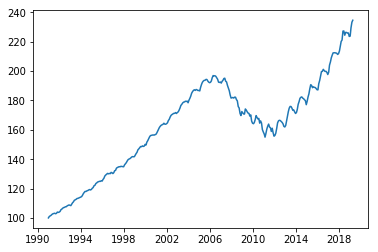

ESC


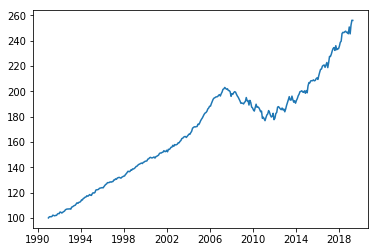

MA


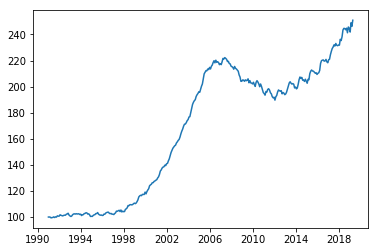

MT


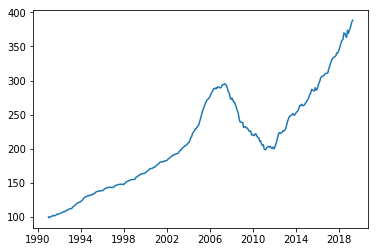

NE


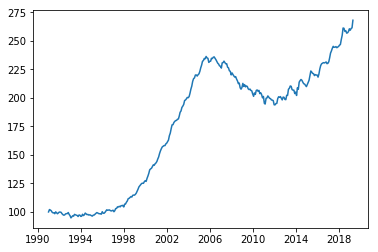

PAC


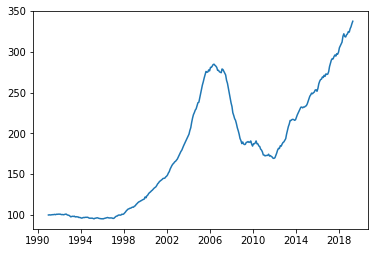

SA


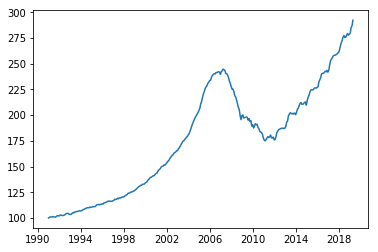

WNC


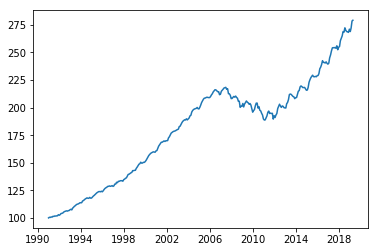

WSC


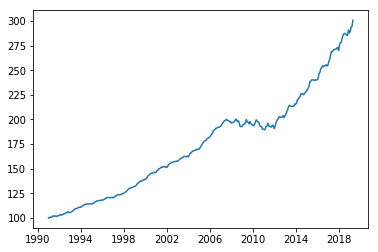

USA


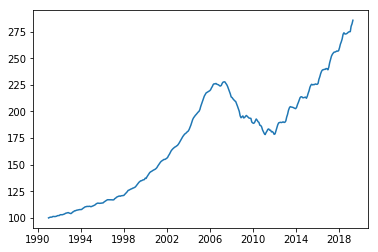

In [16]:
for col in new_div_po_monthly.columns:
    print col
    plt.plot(new_div_po_monthly[col])
    plt.show()

# po quarterly

In [17]:
def read_po_quarterly_hpi():
    df=master[(master['frequency']=='quarterly') & (master['level']=='State') 
       & (master['hpi_type']=='traditional') & (master['hpi_flavor']=='purchase-only')]
    df=df[df['place_id'].isin({'CA','OH','NC','IA','NY'})]
    m={1:2,2:5,3:8,4:11}
    df['month'] = df[['yr','period']].apply(lambda u: pd.to_datetime('{}-{}-1'.format(u.values[0],m[u.values[1]]-1)),axis=1)
    df=pd.pivot_table(df,index=['month'], columns=['place_id'],values=['index_nsa'] )
    df.columns = df.columns.droplevel()
    df.columns=df.columns.map(lambda u: u.replace("DV_",""))
    #df=df[["MA",'ENC','WNC','SA','PAC']]    
    return df 

In [18]:
state_po_quarterly=read_po_quarterly_hpi()

In [19]:
state_po_quarterly.tail()

place_id        CA      IA      NC      NY      OH
month                                             
2017-01-01  255.24  230.00  220.06  225.57  183.31
2017-04-01  265.02  235.84  231.17  230.91  192.41
2017-07-01  269.43  240.18  230.80  236.75  195.50
2017-10-01  272.13  239.46  233.36  239.01  194.49
2018-01-01  277.87  239.88  238.69  239.58  196.82

In [20]:
def pred(col,b_show=False):
    m = Prophet(seasonality_mode = 'multiplicative' )#, mcmc_samples=300)
    #m = Prophet()
    df=state_po_quarterly[col].reset_index()
    df.columns=['ds','y']
    df=df[df['ds']>=pd.to_datetime('2012-01-01')]
    m.fit(df)
    future = m.make_future_dataframe(include_history=False, periods=4, freq='Q')
    fcst = m.predict(future)
    if b_show:
        fig = m.plot(fcst)
        plt.show()
    fcst['ds']=fcst['ds']+pd.Timedelta(days=1)
    fcst=fcst[['ds','yhat']].set_index('ds')
    fcst.columns=[col]
    return m,fcst

In [21]:
lst=[]
for col in state_po_quarterly.columns:
    m,fcst=pred(col)
    lst.append(fcst)

INFO:fbprophet.forecaster:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet.forecaster:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet.forecaster:n_changepoints greater than number of observations.Using 19.0.
/home/bo/miniconda2/envs/python27/lib/python2.7/site-packages/fbprophet/forecaster.py:353: DeprecationWarning: object of type <type 'numpy.float64'> cannot be safely interpreted as an integer.
  np.linspace(0, hist_size - 1, self.n_changepoints + 1)
INFO:fbprophet.forecaster:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet.forecaster:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet.forecaster:n_changepoints greater than number of observations.Using 19.0.
INFO:fbprophet.forecaster:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
I

In [22]:
lst=pd.concat(lst,axis=1)

In [23]:
new_state_po_quarterly=pd.concat([state_po_quarterly,lst])

In [24]:
lst

CA          IA          NC          NY          OH
ds                                                                    
2018-04-01  281.136886  245.401957  247.406250  243.261504  203.149872
2018-07-01  285.062411  245.978837  250.980454  250.373859  205.597159
2018-10-01  290.674044  249.588980  250.444830  247.733430  207.755245
2019-01-01  298.953936  248.620113  256.522247  249.717760  208.525789

In [25]:
new_state_po_quarterly.to_csv("../input/third2/HPI_state_PO_quarterly_hist_with_forecast.csv")

CA


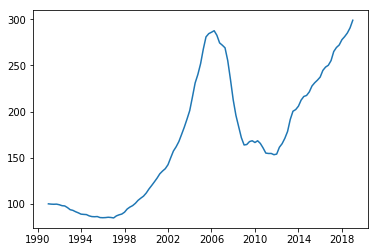

IA


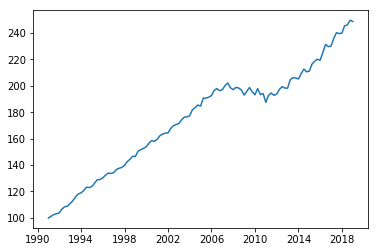

NC


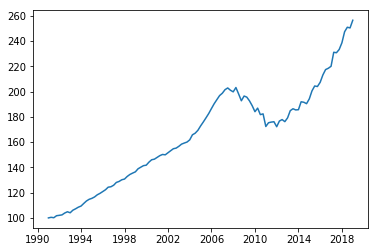

NY


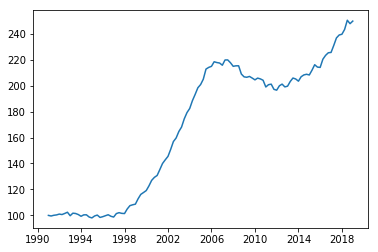

OH


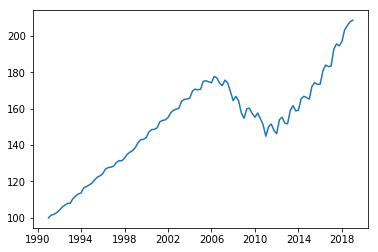

In [26]:
for col in new_state_po_quarterly.columns:
    print col
    plt.plot(new_state_po_quarterly[col])
    plt.show()

# AT

In [27]:
set(master['hpi_flavor'])

{'all-transactions', 'expanded-data', 'purchase-only'}

In [28]:
def read_po_quarterly_hpi():
    df=master[(master['frequency']=='quarterly') & (master['level']=='State') 
       & (master['hpi_type']=='traditional') & (master['hpi_flavor']=='all-transactions')]
    df=df[df['place_id'].isin({'CA','OH','NC','IA','NY'})]
    m={1:2,2:5,3:8,4:11}
    df['month'] = df[['yr','period']].apply(lambda u: pd.to_datetime('{}-{}-1'.format(u.values[0],m[u.values[1]]-1)),axis=1)
    df=pd.pivot_table(df,index=['month'], columns=['place_id'],values=['index_nsa'] )
    df.columns = df.columns.droplevel()
    df.columns=df.columns.map(lambda u: u.replace("DV_",""))
    #df=df[["MA",'ENC','WNC','SA','PAC']]    
    return df 

In [29]:
state_po_quarterly=read_po_quarterly_hpi()

In [30]:
state_po_quarterly.tail()

place_id        CA      IA      NC      NY      OH
month                                             
2017-01-01  590.62  281.18  347.59  633.52  267.10
2017-04-01  604.36  285.79  360.10  644.83  276.95
2017-07-01  616.05  290.88  364.07  657.60  281.04
2017-10-01  627.10  292.17  366.19  664.39  281.40
2018-01-01  638.37  292.24  372.17  671.41  283.87

In [31]:
def pred(col,b_show=False):
    m = Prophet(seasonality_mode = 'multiplicative' )#, mcmc_samples=300)
    #m = Prophet()
    df=state_po_quarterly[col].reset_index()
    df.columns=['ds','y']
    df=df[df['ds']>=pd.to_datetime('2012-01-01')]
    m.fit(df)
    future = m.make_future_dataframe(include_history=False, periods=4, freq='Q')
    fcst = m.predict(future)
    if b_show:
        fig = m.plot(fcst)
        plt.show()
    fcst['ds']=fcst['ds']+pd.Timedelta(days=1)
    fcst=fcst[['ds','yhat']].set_index('ds')
    fcst.columns=[col]
    return m,fcst

In [32]:
lst=[]
for col in state_po_quarterly.columns:
    m,fcst=pred(col)
    lst.append(fcst)

INFO:fbprophet.forecaster:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet.forecaster:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet.forecaster:n_changepoints greater than number of observations.Using 19.0.
INFO:fbprophet.forecaster:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet.forecaster:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet.forecaster:n_changepoints greater than number of observations.Using 19.0.
INFO:fbprophet.forecaster:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet.forecaster:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet.forecaster:n_changepoints greater than number of observations.Using 19.0.
INFO:fbprophet.forecaster:Disabling weekly season

In [33]:
lst=pd.concat(lst,axis=1)

In [34]:
new_state_po_quarterly=pd.concat([state_po_quarterly,lst])

In [35]:
lst

CA          IA          NC          NY          OH
ds                                                                    
2018-04-01  651.637306  300.407077  383.676557  670.328402  290.630644
2018-07-01  670.740186  304.349254  384.826066  675.771175  294.480561
2018-10-01  682.019869  306.888756  389.581626  680.267645  300.016339
2019-01-01  688.788661  306.622399  402.225795  701.173705  308.178418

In [36]:
new_state_po_quarterly.to_csv("../input/third2/HPI_state_AT_quarterly_hist_with_forecast.csv")

CA


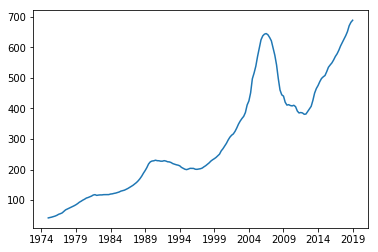

IA


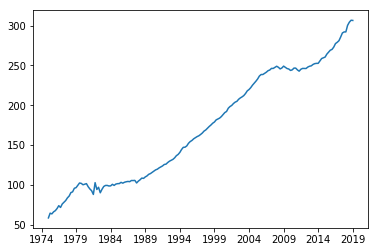

NC


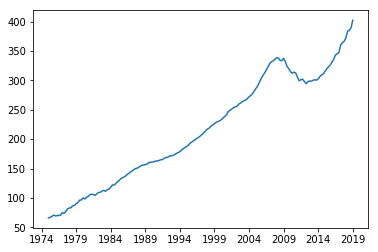

NY


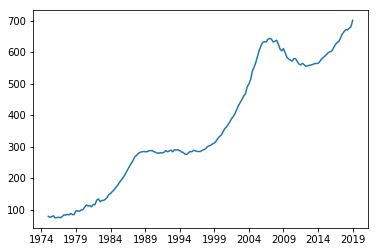

OH


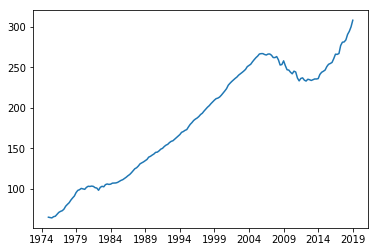

In [37]:
for col in new_state_po_quarterly.columns:
    print col
    plt.plot(new_state_po_quarterly[col])
    plt.show()